Part 0: Setup

In [1]:
from bs4 import BeautifulSoup, Comment
import pandas as pd
import time
import numpy as np
import requests
import matplotlib.pyplot as plt


In [2]:
URL = 'https://www.basketball-reference.com/teams/NYK/2025.html#per_game_stats'  
TABLE_ID = 'per_game_stats'

Part One: Webscraping

In [3]:
def fetch_page(url):
    
    
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
                          ' AppleWebKit/537.36 (KHTML, like Gecko)'
                          ' Chrome/115.0.0.0 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx or 5xx)
        return response.text
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching the page: {http_err}")
    except Exception as err:
        print(f"An error occurred while fetching the page: {err}")
    return None

def parse_table(html_content, table_id):
  
    soup = BeautifulSoup(html_content, 'html.parser')

    # Search for the table within HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        comment_soup = BeautifulSoup(comment, 'html.parser')
        table = comment_soup.find('table', id=table_id)
        if table:
            print(f"Found the table '{table_id}' within HTML comments.")
            return pd.read_html(str(table))[0]

    # If the table wasn't found within comments, search the main HTML
    table = soup.find('table', id=table_id)
    if table:
        print(f"Found the table '{table_id}' in the main HTML.")
        return pd.read_html(str(table))[0]

    print(f"Table with id '{table_id}' not found.")
    return None

def clean_dataframe(df):
   
    # Drop the 'Rk' column if it's just a ranking index
    if 'Rk' in df.columns:
        df = df.drop(columns=['Rk'])

    # Rename columns for clarity (optional)
    df.columns = [col.replace('*', '').strip() for col in df.columns]

    # Further cleaning steps can be added here as needed

    return df

def main(url, table_id):
   
    # Step 1: Fetch the webpage content
    print(f"Fetching the webpage: {url}")
    html_content = fetch_page(url)

    if not html_content:
        print("Failed to retrieve the webpage content.")
        return None

    # Step 2: Parse and extract the table
    print(f"Parsing the table with id '{table_id}'...")
    df = parse_table(html_content, table_id)

    if df is not None:
        # Step 3: Clean the DataFrame
        df = clean_dataframe(df)
        return df
    else:
        print("Failed to extract the desired table.")
        return None


if __name__ == "__main__":
    url = 'https://www.basketball-reference.com/teams/NYK/2025.html#per_game_stats'

    table_id = 'per_game_stats'

    df = main(url, table_id)

    if df is not None:
        print("\nExtracted DataFrame:")
        print(df)  # Prints the entire DataFrame

        print("\nData extraction successful.")
    else:
        print("Data extraction was unsuccessful.")


Fetching the webpage: https://www.basketball-reference.com/teams/NYK/2025.html#per_game_stats
Parsing the table with id 'per_game_stats'...


C:\Users\mikey\AppData\Local\Temp\ipykernel_1436\3111969890.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(comment, 'html.parser')


Found the table 'per_game_stats' in the main HTML.

Extracted DataFrame:
                Player   Age  Pos   G  GS     MP    FG   FGA    FG%    3P  \
0        Mikal Bridges  28.0   SF  37  37   39.2   7.7  15.2  0.506   2.4   
1            Josh Hart  29.0   SG  36  36   37.7   5.4   9.5  0.563   1.3   
2           OG Anunoby  27.0   PF  37  37   36.5   6.2  13.1  0.474   2.1   
3        Jalen Brunson  28.0   PG  36  36   35.0   8.6  18.1  0.478   2.3   
4   Karl-Anthony Towns  29.0    C  34  34   34.6   9.1  16.5  0.550   2.1   
5        Miles McBride  24.0   PG  28   0   24.5   3.4   8.1  0.425   1.9   
6     Precious Achiuwa  25.0   PF  16   1   19.0   2.3   4.4  0.521   0.3   
7        Cameron Payne  30.0   PG  31   1   15.4   2.5   5.9  0.423   1.5   
8         Jericho Sims  26.0    C  31   3   11.9   0.8   1.2  0.632   0.0   
9        Landry Shamet  27.0   SG   8   0   11.5   1.3   2.8  0.455   0.4   
10      Ariel Hukporti  22.0    C  12   0    8.3   0.8   1.2  0.643   0.0   
11 

C:\Users\mikey\AppData\Local\Temp\ipykernel_1436\3111969890.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_html(str(table))[0]


Part Two: Cleaning

In [4]:
#Identify missing values
df.isnull().sum()

Player     0
Age        1
Pos        1
G          0
GS         0
MP         0
FG         0
FGA        0
FG%        0
3P         0
3PA        0
3P%        2
2P         0
2PA        0
2P%        0
eFG%       0
FT         0
FTA        0
FT%        3
ORB        0
DRB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
Awards    16
dtype: int64

Handling Missing Values

In [5]:
df['3P%'] = df['3P%'].fillna(df['3PA'].ffill())
df['Age'] = df['Age'].fillna(df['Player'].ffill())
df['Pos'] = df['Pos'].fillna(df['Player'].ffill())

In [6]:
df.drop('Awards', axis = 1, inplace = True)

Part Three: Implementing Model

In [7]:
data_conv = df.to_csv('data.csv', index=False)

In [8]:
data = pd.read_csv('data.csv')
data.head()

,Player,Age,Pos,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Mikal Bridges,28.0,SF,37,37,39.2,7.7,15.2,0.506,2.4,...,0.705,0.9,2.4,3.3,3.2,1.1,0.5,1.6,1.5,18.6
1,Josh Hart,29.0,SG,36,36,37.7,5.4,9.5,0.563,1.3,...,0.814,1.9,7.2,9.1,5.6,1.4,0.4,1.9,2.5,14.3
2,OG Anunoby,27.0,PF,37,37,36.5,6.2,13.1,0.474,2.1,...,0.788,1.2,3.7,4.9,1.9,1.4,0.9,1.3,2.4,16.3
3,Jalen Brunson,28.0,PG,36,36,35.0,8.6,18.1,0.478,2.3,...,0.824,0.5,2.4,2.9,7.6,0.8,0.1,2.4,2.3,25.3
4,Karl-Anthony Towns,29.0,C,34,34,34.6,9.1,16.5,0.550,2.1,...,0.828,3.0,11.0,14.0,3.4,0.9,0.9,2.6,3.6,25.3


In [9]:
def gradient_descent(m_now, b_now, points, L):
    m_gradient = 0
    b_gradient = 0
    n = len(points)
    for i in range(n):
        x = points.iloc[i]['GS']
        y = points.iloc[i]['TOV']
    
        m_gradient += -(2/n) * x * (y - (m_now * x + b_now))
        b_gradient += -(2/n) * (y - (m_now * x + b_now))
    m = m_now - m_gradient * L
    b = b_now - b_gradient * L

    return m,b

Testing Model

0.10635902484419255 0.008358810097779223


Text(0.5, 1.0, 'Games Started vs Turnovers Per Game')

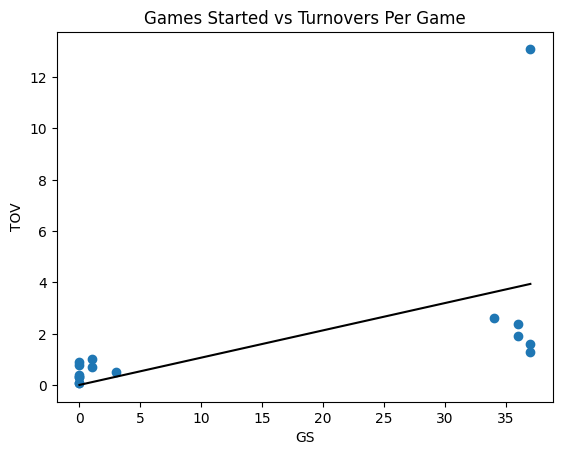

In [20]:
m = 0
b = 0
L = 0.000001
epochs  = 10000

for i in range(epochs):
    m,b = gradient_descent(m,b,df,L)
print(m,b)

plt.scatter(df['GS'],df['TOV'])
plt.plot(list(range(0,38)), [m*x + b for x in range(0,38)], color='black')
plt.xlabel('GS')
plt.ylabel('TOV')
plt.title('Games Started vs Turnovers Per Game')


In [21]:
r = df['GS'].corr(df['TOV'])
print(f"The correlation between 'Games Started' and 'Turnovers Per Game' is: {r}")

The correlation between 'Games Started' and 'Turnovers Per Game' is: 0.537233264510798
